In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/myanimelist/manga.csv
/kaggle/input/myanimelist/anime.csv


In [91]:
import pandas as pd
import numpy as np
import difflib
import sklearn as skl
from sklearn.pipeline import Pipeline
import spacy
import nltk as nltk
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.simplefilter("ignore")

In [92]:
new_df = pd.read_csv("/kaggle/input/myanimelist/anime.csv")
manga = pd.read_csv("/kaggle/input/myanimelist/manga.csv")

In [93]:
new_df.shape

(24985, 39)

In [94]:
anime = new_df.iloc[:1500,:]

In [95]:
anime.info()
anime.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anime_id          1500 non-null   int64  
 1   title             1500 non-null   object 
 2   type              1500 non-null   object 
 3   score             1500 non-null   float64
 4   scored_by         1500 non-null   int64  
 5   status            1500 non-null   object 
 6   episodes          1496 non-null   float64
 7   start_date        1500 non-null   object 
 8   end_date          1490 non-null   object 
 9   source            1500 non-null   object 
 10  members           1500 non-null   int64  
 11  favorites         1500 non-null   int64  
 12  episode_duration  1500 non-null   object 
 13  total_duration    1496 non-null   object 
 14  rating            1500 non-null   object 
 15  sfw               1500 non-null   bool   
 16  approved          1500 non-null   bool   


anime_id              0
title                 0
type                  0
score                 0
scored_by             0
status                0
episodes              4
start_date            0
end_date             10
source                0
members               0
favorites             0
episode_duration      0
total_duration        4
rating                0
sfw                   0
approved              0
created_at            0
updated_at            0
start_year            0
start_season          0
real_start_date       0
real_end_date        10
broadcast_day       661
broadcast_time      676
genres                0
themes                0
demographics          0
studios               0
producers             0
licensors             0
synopsis              0
background          892
main_picture          0
url                   0
trailer_url         323
title_english       165
title_japanese        1
title_synonyms        0
dtype: int64

In [96]:
anime.type.value_counts()

type
tv         953
movie      281
ova        120
special     90
ona         51
music        5
Name: count, dtype: int64

In [97]:
manga.type.value_counts()

type
manga          44077
light_novel    10224
one_shot        5248
manhwa          2986
doujinshi       1816
manhua           350
novel            132
Name: count, dtype: int64

In [98]:
common_cols = []
anime_cols = anime.columns
manga_cols = manga.columns
for i in anime_cols:
    if i in manga_cols:
        common_cols.append(i)

len(common_cols)

24


1. All the columns presesent in manga df is not present in anime df and vice versaHence
2. both df has some unique columns
3. Conclusion: we cannot concat the whole datsets....but can concat selected necessary columns


In [99]:
duplicates = anime[anime.duplicated(subset=['title'], keep=False)]
anime = anime.drop_duplicates(subset = ['title'],keep='first')

ALL DUPLICATES DROPPED

In [100]:
import re

In [101]:
anime.genres
pattern = r"[,\'\[\]]"
anime['genres'] = anime['genres'].apply(lambda x: re.sub(pattern, "", x))

In [102]:
anime.themes
attern = r"[,\'\[\]]"
anime['themes'] = anime['themes'].apply(lambda x: re.sub(pattern, "", x))

In [103]:
anime.themes

0                            Military
1                                    
2              Gore Military Survival
3           Psychological Time Travel
4                    Romantic Subtext
                    ...              
1495                  Military School
1496                       Video Game
1497               Harem Mecha School
1498    Historical Military Mythology
1499              Harem Parody School
Name: themes, Length: 1500, dtype: object

In [104]:
anime.demographics
attern = r"[,\'\[\]]"
anime['demographics'] = anime['demographics'].apply(lambda x: re.sub(pattern, "", x))

In [105]:
anime.demographics

0       Shounen
1       Shounen
2       Shounen
3              
4       Shounen
         ...   
1495           
1496           
1497           
1498     Seinen
1499           
Name: demographics, Length: 1500, dtype: object

In [106]:
anime.studios
attern = r"[,\'\[\]]"
anime['studios'] = anime['studios'].apply(lambda x: re.sub(pattern, "", x))

In [107]:
anime.studios

0                 Bones
1              Madhouse
2            Wit Studio
3             White Fox
4       Kyoto Animation
             ...       
1495              Actas
1496       A-1 Pictures
1497          J.C.Staff
1498          J.C.Staff
1499        Studio Deen
Name: studios, Length: 1500, dtype: object

In [108]:
anime['synopsis'] = anime['synopsis'].fillna('')
anime['background'] = anime['background'].fillna('')

In [109]:
anime.background

0                                                        
1                                                        
2       Shingeki no Kyojin adapts content from volumes...
3       Steins;Gate is based on 5pb. and Nitroplus' vi...
4       Koe no Katachi won the following awards: Japan...
                              ...                        
1495                                                     
1496                                                     
1497    Date A Live III adapts novels 8-12 of Koushi T...
1498                                                     
1499                                                     
Name: background, Length: 1500, dtype: object

In [110]:
features = ['title','rating','genres','themes','demographics','synopsis','background']

In [111]:
anime['combined_feature'] = anime.title+' '+anime.rating+' '+anime.genres+' '+anime.themes+' '+anime.demographics+' '+anime.synopsis+' '+anime.background

In [112]:
anime.isnull().sum()

anime_id              0
title                 0
type                  0
score                 0
scored_by             0
status                0
episodes              4
start_date            0
end_date             10
source                0
members               0
favorites             0
episode_duration      0
total_duration        4
rating                0
sfw                   0
approved              0
created_at            0
updated_at            0
start_year            0
start_season          0
real_start_date       0
real_end_date        10
broadcast_day       661
broadcast_time      676
genres                0
themes                0
demographics          0
studios               0
producers             0
licensors             0
synopsis              0
background            0
main_picture          0
url                   0
trailer_url         323
title_english       165
title_japanese        1
title_synonyms        0
combined_feature      0
dtype: int64

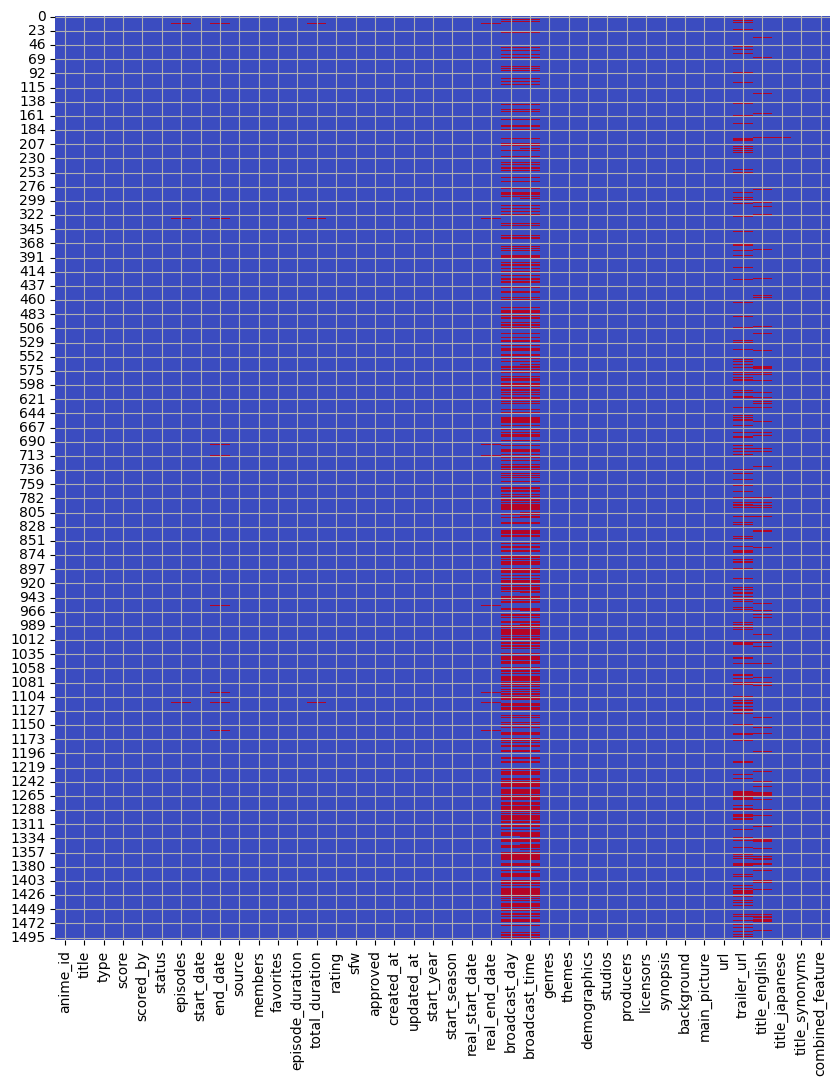

In [113]:
plt.figure(figsize=(10,12))
sns.heatmap(anime.isnull(),cbar=False,cmap='coolwarm')
plt.grid(True)
plt.show()


In [114]:
#Dropping 579 null values from combined_feature
anime['combined_feature'] = anime['combined_feature'].dropna(axis=0)

In [115]:
anime.combined_feature[16676:17000]

Series([], Name: combined_feature, dtype: object)

In [116]:
anime[anime['combined_feature'].isna()]

,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms,combined_feature


In [117]:
anime.dropna(subset=['combined_feature'], inplace=True)

In [118]:
anime.isnull().sum()

anime_id              0
title                 0
type                  0
score                 0
scored_by             0
status                0
episodes              4
start_date            0
end_date             10
source                0
members               0
favorites             0
episode_duration      0
total_duration        4
rating                0
sfw                   0
approved              0
created_at            0
updated_at            0
start_year            0
start_season          0
real_start_date       0
real_end_date        10
broadcast_day       661
broadcast_time      676
genres                0
themes                0
demographics          0
studios               0
producers             0
licensors             0
synopsis              0
background            0
main_picture          0
url                   0
trailer_url         323
title_english       165
title_japanese        1
title_synonyms        0
combined_feature      0
dtype: int64

In [119]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [120]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS
len(stop_words)

318

In [121]:
import spacy
from nltk.stem import PorterStemmer
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()
stop_words = STOP_WORDS
def preprocess(x):
    doc = nlp(x)
    processed_words = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        lemma = token.lemma_.lower()
        stemmed = stemmer.stem(lemma)
        processed_words.append(stemmed)

    return ' '.join(processed_words)


In [122]:
anime['processed_feature'] = anime['combined_feature'].apply(preprocess)

0        fullmet alchemist brotherhood r action adventu...
1        hunter x hunter 2011 pg_13 action adventur fan...
2        shingeki kyojin season 3 2 r action drama gore...
3        steins;gat pg_13 drama sci fi suspens psycholo...
4        koe katachi pg_13 award win drama romant subte...
                               ...                        
24980    seizoki g avant gard    anim kaki mation techn...
24981    kanshaj g   music kid music video song kanshaj...
24982    kaijuu sekai seifuku g slice life pet   follow...
24983    yotsukado melodi g   music kid music video son...
24984    ame kusari pg_13 drama music psycholog   music...
Name: processed_feature, Length: 24405, dtype: object

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vector_features = vectorizer.fit_transform(anime.processed_feature.values)

In [82]:
vector_features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [83]:
similarity = cosine_similarity(vector_features)

In [84]:
anime.title[:500]

0                     Fullmetal Alchemist: Brotherhood
1                               Hunter x Hunter (2011)
2                   Shingeki no Kyojin Season 3 Part 2
3                                          Steins;Gate
4                                       Koe no Katachi
                            ...                       
495    Fate/Grand Order: Zettai Majuu Sensen Babylonia
496                             Haikyuu!! Riku vs. Kuu
497                          Jujutsu Kaisen 2nd Season
498                                      Prison School
499                        Karakai Jouzu no Takagi-san
Name: title, Length: 500, dtype: object

In [85]:
def recommender(anime_name):
    anime_index = anime[anime['title']==anime_name].index[0]
    distances = similarity[anime_index]
    anime_list = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:6]
    for i in anime_list:
        print(anime.iloc[i[0]].title)

In [86]:
recommender('Fullmetal Alchemist: Brotherhood')

Fullmetal Alchemist
Fullmetal Alchemist: The Conqueror of Shamballa
Fullmetal Alchemist: Brotherhood Specials
Houseki no Kuni
Dororo


In [87]:
import pickle as pkl

In [88]:
pkl.dump(anime,open('anime.pkl','wb'))

In [89]:
pkl.dump(anime.to_dict(),open('anime_dict','wb'))

In [90]:
with open('similarity.pkl','wb') as f:
    pkl.dump(similarity,f)